# **DEPENDENCIES**

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# **DATASET**

In [29]:
hayden_building_path = "/content/Exterior-of-the-hayden-building.jpg"

# **HARRIS CORNER DETECTION**  
### `gaussian_mask(n, sigma=None)`

This function generates a 1D Gaussian kernel of size `n` with an optional standard deviation `sigma`. If `sigma` is not provided, it calculates an appropriate value based on the kernel size. The Gaussian kernel is used for smoothing and blurring images. Here's a breakdown:

- If `sigma` is not provided, it calculates an appropriate standard deviation `sigma` based on the kernel size.
- It generates a 1D array `X` representing the values from -(n//2) to n//2.
- It computes the Gaussian kernel by applying the Gaussian function to the array `X` using the calculated or provided `sigma`.

### `separable_conv(I, filter_x, filter_y)`

This function performs separable convolution on an input image `I` using two 1D convolution kernels, `filter_x` and `filter_y`. It separates the convolution process into two steps, first in the horizontal direction (`I_a`), and then in the vertical direction (`I_b`). Here's a breakdown:

- It calculates the dimensions of the input image `I` (height and width) and initializes two empty arrays, `I_a` and `I_b`, to store the results of convolution in the horizontal and vertical directions.
- It iterates over the horizontal direction, applying convolution with `filter_x` to obtain `I_a`.
- It then iterates over the vertical direction, applying convolution with `filter_y` to obtain the final result `I_b`.


### `detect(I, n_g=5, n_w=5, k=0.06)`

This is the main detection function, implementing the Harris corner detector. It calculates the corner response and other intermediate results for an input image `I`. Here's a breakdown:

- It calculates the dimensions of the input image `I` (height and width).
- It computes image gradients `I_x` and `I_y` using Sobel operators to detect edges.
- Gaussian smoothing is applied to `I_x` and `I_y` to reduce noise.
- The structure tensor elements `D` are computed using the gradients and Gaussian smoothing.
- The function extracts `P`, `Q`, and `R` from `D` and calculates corner response values `L_1` and `L_2`.
- Finally, the corner response image `C` is computed using the eigenvalues of the structure tensor and the Harris corner response formula.

The function returns `C` (corner response), `I_x` and `I_y` (gradient images), `L_1` and `L_2` (eigenvalues of the structure tensor). These values are used for corner detection and feature extraction in computer vision applications.


In [27]:
def gaussian_mask(n, sigma=None):
    if sigma is None:
        sigma = 0.3 * (n // 2) + 0.8
    X = np.arange(-(n//2), n//2+1)
    kernel = np.exp(-(X**2)/(2*sigma**2))
    return kernel

def seperable_conv(I, filter_x, filter_y):
    h, w = I.shape[:2]
    n = filter_x.shape[0]//2
    I_a = np.zeros(I.shape)
    I_b = np.zeros(I.shape)
    for x in range(n, w-n):
        patch = I[:, x-n:x+n+1]
        I_a[:, x] = np.sum(patch * filter_x, 1)
    filter_y = np.expand_dims(filter_y, 1)
    for y in range(n, h-n):
        patch = I_a[y-n:y+n+1, :]
        I_b[y, :] = np.sum(patch * filter_y, 0)
    return I_b

def detect(I, n_g=5, n_w=5, k=0.06):
    h, w = I.shape
    sobel_1 = np.array([-1, 0, 1])
    sobel_2 = np.array([1, 2, 1])
    I_x = seperable_conv(I, sobel_1, sobel_2)
    I_y = seperable_conv(I, sobel_2, sobel_1)
    g_kernel = gaussian_mask(n_g)
    I_x = seperable_conv(I_x, g_kernel, g_kernel)
    I_y = seperable_conv(I_y, g_kernel, g_kernel)
    D_temp = np.zeros((h, w, 2, 2))
    D_temp[:, :, 0, 0] = np.square(I_x)
    D_temp[:, :, 0, 1] = I_x * I_y
    D_temp[:, :, 1, 0] = D_temp[:, :, 0, 1]
    D_temp[:, :, 1, 1] = np.square(I_y)
    g_filter = gaussian_mask(n_w)
    g_filter = np.dstack([g_filter] * 4).reshape(n_w, 2, 2)
    D = seperable_conv(D_temp, g_filter, g_filter)
    P = D[:, :, 0, 0]
    Q = D[:, :, 0, 1]
    R = D[:, :, 1, 1]
    T1 = (P + R) / 2
    T2 = np.sqrt(np.square(P - R) + 4 * np.square(Q)) / 2
    L_1 = T1 - T2
    L_2 = T1 + T2
    C = L_1 * L_2 - k * np.square(L_1 + L_2)
    return C, I_x, I_y, L_1, L_2

# **TESTING**

1. **Image Loading and Preprocessing**

2. **Corner Detection**

3. **Plotting Gradients `I_x` and `I_y`**

4. **Plotting Eigenvalues `L_1` and `L_2`**

5. **Plotting Corner-ness Map and Detected Corners**


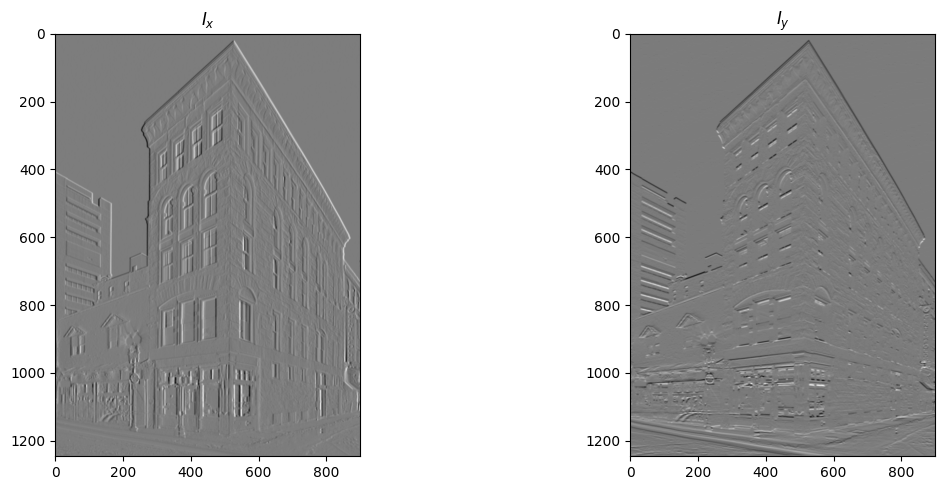

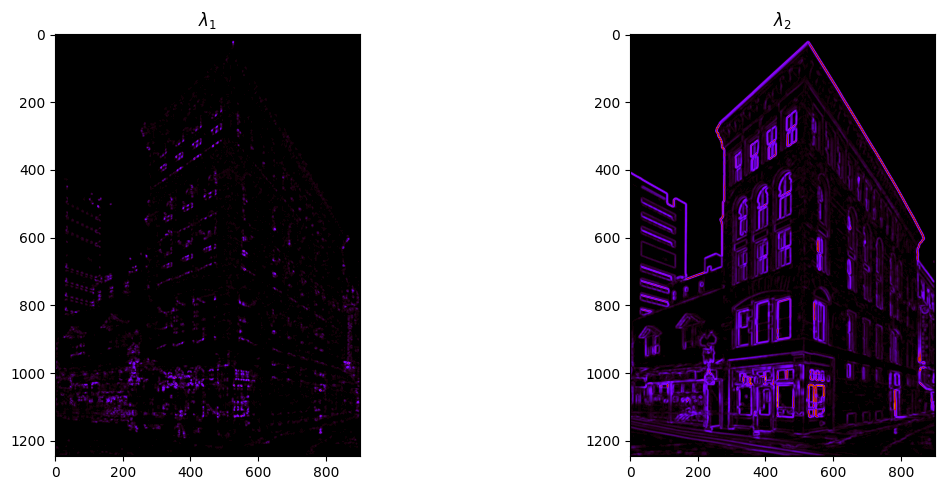

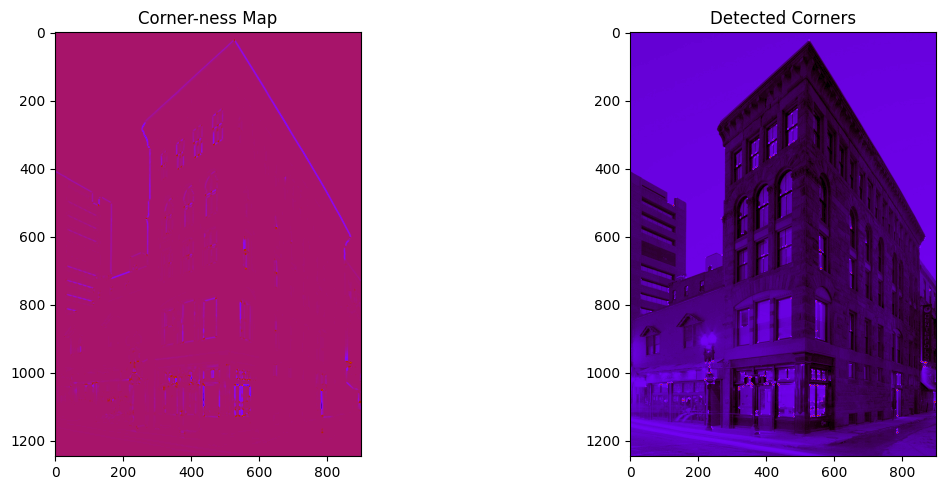

In [30]:
img_path = hayden_building_path
img = np.array(Image.open(img_path).convert('L'))
img = (img - img.min())/(img.max()-img.min())
C, I_x, I_y, L_1, L_2 = detect(img, k=0.06)
C = (C - C.min())/(C.max()-C.min())

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.title('$I_x$')
plt.imshow(I_x, cmap='gray')
plt.subplot(122)
plt.title('$I_y$')
plt.imshow(I_y, cmap='gray')
plt.tight_layout()
plt.show()


plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.title(r'$\lambda_1$')
plt.imshow(L_1, cmap='gnuplot')
# plt.colorbar()
plt.subplot(122)
plt.title(r'$\lambda_2$')
plt.imshow(L_2, cmap='gnuplot')
# plt.colorbar()
plt.tight_layout()
plt.show()


plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.imshow(C-0.457, cmap='gnuplot')
plt.title('Corner-ness Map')
plt.subplot(122)
plt.imshow(img/2+2*C*(C >= 0.457), cmap='gnuplot')
plt.title('Detected Corners')
plt.tight_layout()
plt.show()